In [1]:
import numpy as np

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import os, os.path
import keras
import time
import scipy.misc
import scipy.ndimage

from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

from keras.utils import np_utils
from keras.optimizers import Adam
from keras.callbacks import CSVLogger

from keras import backend as K
from keras.initializers import RandomUniform, RandomNormal

from PIL import Image

from tqdm import tqdm
from datetime import datetime

%matplotlib inline

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K40m (CNMeM is disabled, cuDNN 5110)


In [2]:
# resolution of images

h = 75
w = 100

In [3]:
#Creates list of positiv files
positiv_list = glob.glob('/fhgfs/groups/e5/lhcb/detector/scifi/windingcontrol/Images_Sep17/pos/IMG_*.png')
#Finds the number of positiv files
positiv_len = len(positiv_list)
print("Size of positiv Sample: {}".format(positiv_len))

#Same but for negativ files
negativ_list = glob.glob('/fhgfs/groups/e5/lhcb/detector/scifi/windingcontrol/Images_Sep17/neg/IMG_*.png')
negativ_len = len(negativ_list)
print("Size of negativ Sample: {}".format(negativ_len))

Size of positiv Sample: 8590
Size of negativ Sample: 13846


In [4]:
X_posind = []
X_negind = []
X_posinu = []
X_neginu = []
X_posinl = []
X_neginl = []
X_posinr = []
X_neginr = []

X_pos = []
X_neg = []

for fname in tqdm(positiv_list):
    img = scipy.misc.imresize(np.array(Image.open(fname)),(h,w))
    
    #X_posind.append(scipy.ndimage.interpolation.shift(img, (20,0), output=None, order=1, mode='nearest', cval=0.0, prefilter=True))
    #X_posinu.append(scipy.ndimage.interpolation.shift(img, (-20,0), output=None, order=1, mode='nearest', cval=0.0, prefilter=True))
    
    #X_posinr.append(scipy.ndimage.interpolation.shift(img, (0,50), output=None, order=1, mode='reflect', cval=0.0, prefilter=True))
    #X_posinl.append(scipy.ndimage.interpolation.shift(img, (0,-50), output=None, order=1, mode='reflect', cval=0.0, prefilter=True))
    
    X_pos.append(img) 
    
# Random picking of neg images with the given ratio to the pos images
ratio_pos_neg = 1
    
for fname in tqdm(np.random.choice(negativ_list, replace=False, size=int(len(X_pos) / ratio_pos_neg))):
    img = scipy.misc.imresize(np.array(Image.open(fname)),(h,w))
    
    #X_negind.append(scipy.ndimage.interpolation.shift(img, (20,0), output=None, order=1, mode='nearest', cval=0.0, prefilter=True))
    #X_neginu.append(scipy.ndimage.interpolation.shift(img, (-20,0), output=None, order=1, mode='nearest', cval=0.0, prefilter=True))
    
    #X_neginr.append(scipy.ndimage.interpolation.shift(img, (0,50), output=None, order=1, mode='reflect', cval=0.0, prefilter=True))
    #X_neginl.append(scipy.ndimage.interpolation.shift(img, (0,-50), output=None, order=1, mode='reflect', cval=0.0, prefilter=True))
    
    X_neg.append(img)

100%|██████████| 8590/8590 [03:40<00:00, 31.45it/s]


In [5]:
X_posind = np.array(X_posind)
X_negind = np.array(X_negind)
X_posinu = np.array(X_posinu)
X_neginu = np.array(X_neginu)
X_posinl = np.array(X_posinl)
X_neginl = np.array(X_neginl)
X_posinr = np.array(X_posinr)
X_neginr = np.array(X_neginr)
X_pos = np.array(X_pos)
X_neg = np.array(X_neg)

In [6]:
X_all = np.concatenate((X_pos, X_neg), axis=0)
Y_all = np.concatenate( ( np.ones(len(X_pos)), np.zeros(len(X_neg)) ) , axis=0)
#X_all_trans = np.concatenate((X_pos, X_posind, X_posinu, X_posinl, X_posinr, X_neg, X_negind, X_neginu, X_neginl, X_neginr), axis=0)
#Y_all_trans = np_utils.to_categorical(np.concatenate((np.ones((5*positiv_len, 1)), np.zeros((5*negativ_len,1))), axis=0), 2)

In [7]:
X_all.shape

(17180, 75, 100)

In [8]:
Y_all.shape

(17180,)

In [9]:
#Shuffling the order of the input - required to avoid batches selecting only positive/negative images
randomize = np.arange(len(X_all))
np.random.shuffle(randomize)
X_all = X_all[randomize]
Y_all = Y_all[randomize]

In [10]:
# Check labeling of Data
if False:
    for i, img in enumerate(X_all[:200]):
        plt.imshow(np.squeeze(img), cmap='gray')

        name = "Good img" if Y_all[i] == 1 else "Bad img"
        plt.title('{}.'.format(name))
        plt.savefig('../Plots/TestImg/{}.png'.format(i))
        if i%10 == 0:
            print("10 written")
        i+=1

In [11]:
# Hold 5% back as training data
train_split = int(0.05 * len(X_all))

# Separate in Training and Testing Sample
X_train = X_all[train_split:]
Y_train = Y_all[train_split:]

X_test = X_all[:train_split]
Y_test = Y_all[:train_split]

In [12]:
# Check labeling of Data
if False:
    for i, img in enumerate(X_test[:100]):
        plt.imshow(np.squeeze(img), cmap='gray')

        name = "Good img" if Y_test[i] == 1 else "Bad img"
        plt.title('{}.'.format(name))
        plt.savefig('../Plots/TestImg/{}.png'.format(i))
        if i%10 == 0:
            print("10 written")
        i+=1

In [13]:
X_train = X_train.reshape(X_train.shape[0], h, w, 1)
X_test = X_test.reshape(X_test.shape[0], h, w, 1)

#Shape check (NumberofImages, Height, Width, Depth)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(16321, 75, 100, 1)
(16321,)
(859, 75, 100, 1)
(859,)


### Test with lower resolution

In [64]:
x_new = 30
y_new = 40

In [65]:
X_all_30_40 = []
for img in X_all:
    X_all_30_40.append(scipy.misc.imresize(np.array(img),(x_new,y_new)))
    
X_all_30_40 = np.array(X_all_30_40)
Y_all_30_40 = Y_all

In [ ]:
#Shuffling the order of the input - required to avoid batches selecting only positive/negative images
randomize = np.arange(len(X_all))
np.random.shuffle(randomize)
X_all_30_40 = X_all_30_40[randomize]
Y_all_30_40 = Y_all_30_40[randomize]

In [ ]:
# Hold 5% back as training data
train_split = int(0.05 * len(X_all_30_40))

# Separate in Training and Testing Sample
X_train_30_40 = X_all_30_40[train_split:]
Y_train_30_40 = Y_all_30_40[train_split:]

X_test_30_40 = X_all_30_40[:train_split]
Y_test_30_40 = Y_all_30_40[:train_split]

In [ ]:
X_train_30_40 = X_train_30_40.reshape(X_train_30_40.shape[0], x_new, y_new, 1)
X_test_30_40 = X_test_30_40.reshape(X_test_30_40.shape[0], x_new, y_new, 1)

# Data need to be normalised
* Mean and StdDev for each pixel over whole data set

In [14]:
X_train.shape

(16321, 75, 100, 1)

In [15]:
means = np.mean(X_train, axis=0)
stds = np.std(X_train, axis=0)

#means_30_40 = np.mean(X_train_30_40, axis=0)
#stds_30_40 = np.std(X_train_30_40, axis=0)

In [16]:
print(means.shape)
print(stds.shape)
#print(means_30_40.shape)
#print(stds_30_40.shape)

(75, 100, 1)
(75, 100, 1)


In [17]:
path_meanstd = '../TrainedModels/' + str(datetime.now().strftime('%Y-%m-%d')) + '/MeansStdDev/'

if not os.path.exists(path_meanstd):
    os.makedirs(path_meanstd)
    print('Created path: {}'.format(path_meanstd))
                                            
#np.savetxt('../Data/Means_30_40.txt', means_30_40)
#np.savetxt('../Data/StdDev_30_40.txt', stds_30_40)
np.savetxt(path_meanstd +'Means_' +  str(datetime.now().strftime('%Y-%m-%d_%H-%M-%S')) +  '.txt', means)
np.savetxt(path_meanstd +'StdDev_' +  str(datetime.now().strftime('%Y-%m-%d_%H-%M-%S')) +  '.txt', stds)

Created path: ../TrainedModels/2017-09-15/MeansStdDev/


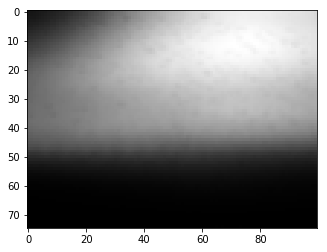

In [18]:
plt.imshow(np.squeeze(means), cmap='gray')
plt.savefig(path_meanstd + 'MeanImg' +  str(datetime.now().strftime('%Y-%m-%d_%H-%M-%S')) + '.png')

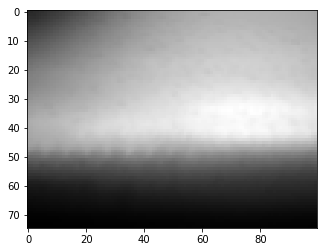

In [19]:
plt.imshow(np.squeeze(stds), cmap='gray')
plt.savefig(path_meanstd + 'StdImg' +  str(datetime.now().strftime('%Y-%m-%d_%H-%M-%S')) + '.png')

In [20]:
X_train_norm = np.array([(img-means)/stds for img in X_train])
X_test_norm = np.array([(img-means)/stds for img in X_test])

In [ ]:
#X_train_30_40_norm = np.array([(img-means_30_40)/stds_30_40 for img in X_train_30_40])
#X_test_30_40_norm = np.array([(img-means_30_40)/stds_30_40 for img in X_test_30_40])

# Let the training begin...

In [21]:
## Class to get loss and accuracy during training of NN

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accuracy = []
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracy.append(logs.get('acc'))

In [22]:
input_shape= (h,w,1)
#input_shape_30_40= (x_new,y_new,1)

* initializer need to have mean = 0 and std 1/input_shape
* for successive layers output shape of previous layer will declare this

In [23]:
path_model = '../TrainedModels/' + str(datetime.now().strftime('%Y-%m-%d')) + '/'

if not os.path.exists(path_model):
    os.makedirs(path_model)
    print('Created path: {}'.format(path_model))

In [174]:
model = Sequential()

# First Convolutional layer initialised with random input weights
model.add(Conv2D(16, (5,5), kernel_initializer=RandomNormal(mean=0, stddev=1/(h*w)), padding='valid', input_shape=input_shape, activation='selu'))
# Reduce size a bit
model.add(MaxPooling2D(pool_size=(2,2)))
mult_shape1 = np.prod(model.layers[1].output_shape[1:])

# Second Convolutional layer
model.add(Conv2D(16, (5,5), kernel_initializer=RandomNormal(mean=0, stddev=1/mult_shape1), padding='valid', activation='selu'))
# Reduce size a bit
model.add(MaxPooling2D(pool_size=(2,2)))
mult_shape2 = np.prod(model.layers[3].output_shape[1:])

# Third Convolutional layer
model.add(Conv2D(16, (3,3), kernel_initializer=RandomNormal(mean=0, stddev=1/mult_shape2), padding='valid', activation='selu'))
# Reduce size a bit
model.add(MaxPooling2D(pool_size=(2,2)))

#Converting the 2D images to 1D vectors
model.add(Flatten())  
mult_shape3 = np.prod(model.layers[6].output_shape[1:])

# First Fully connected layer
model.add(Dense(200, activation='selu', kernel_initializer=RandomNormal(mean=0, stddev=1/mult_shape3)))
model.add(Dropout(0.2))
mult_shape4 = np.prod(model.layers[8].output_shape[1:])

#model.add(Dense(200, activation='selu', kernel_initializer=RandomNormal(mean=0, stddev=1/mult_shape4)))
#model.add(Dropout(0.2))
#mult_shape5 = np.prod(model.layers[10].output_shape[1:])

#Output layer
model.add(Dense(1, activation='sigmoid', kernel_initializer=RandomNormal(mean=0, stddev=1/mult_shape4)))

In [175]:
name='165_165_163_200'

In [176]:
model.summary()

path_data = '../Data/{}/{}/'.format(str(datetime.now().strftime('%Y-%m-%d')), name )

if not os.path.exists(path_data):
    os.makedirs(path_data)
    print('Created path: {}'.format(path_data))

# Open the file
with open(path_data + 'ModelSummary.txt','w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: fh.write(x + '\n'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 71, 96, 16)        416       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 35, 48, 16)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 31, 44, 16)        6416      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 15, 22, 16)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 13, 20, 16)        2320      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 6, 10, 16)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 960)               0         
__________

In [177]:
#Defining optimiser and compiling the model

model.compile(loss='binary_crossentropy', # using the cross-entropy loss function
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              metrics=['accuracy'])

history = LossHistory()

In [178]:
# if you want to continue a training
if False:
    model = load_model('../TrainedModels/2017-09-09/169_167_200_200_selu_100epochs.h5')

In [179]:
model.fit(X_train_norm, Y_train,  batch_size=76, epochs=100, verbose=1, validation_split = 0.05, callbacks=[history])

#Evaluating trained model on test images
score = model.evaluate(X_test_norm, Y_test, verbose=0)
print('Model has accuracy:', score[1]*100,'%')

Train on 15504 samples, validate on 817 samples
Epoch 1/100
15504/15504 [==============================] - 53s - loss: 0.6087 - acc: 0.6604 - val_loss: 0.5449 - val_acc: 0.7099
Epoch 2/100
15504/15504 [==============================] - 54s - loss: 0.4931 - acc: 0.7620 - val_loss: 0.4903 - val_acc: 0.7319
Epoch 3/100
15504/15504 [==============================] - 53s - loss: 0.4049 - acc: 0.8148 - val_loss: 0.3526 - val_acc: 0.8433
Epoch 4/100
15504/15504 [==============================] - 53s - loss: 0.3239 - acc: 0.8594 - val_loss: 0.2911 - val_acc: 0.8727
Epoch 5/100
15504/15504 [==============================] - 53s - loss: 0.2266 - acc: 0.9097 - val_loss: 0.1792 - val_acc: 0.9388
Epoch 6/100
15504/15504 [==============================] - 53s - loss: 0.1581 - acc: 0.9410 - val_loss: 0.1150 - val_acc: 0.9657
Epoch 7/100
15504/15504 [==============================] - 53s - loss: 0.1018 - acc: 0.9649 - val_loss: 0.0862 - val_acc: 0.9694
Epoch 8/100
15504/15504 [========================

15504/15504 [==============================] - 52s - loss: 0.0034 - acc: 0.9994 - val_loss: 0.0044 - val_acc: 0.9976
Epoch 64/100
15504/15504 [==============================] - 52s - loss: 3.2671e-04 - acc: 0.9999 - val_loss: 0.0057 - val_acc: 0.9988
Epoch 65/100
15504/15504 [==============================] - 52s - loss: 1.8153e-04 - acc: 0.9999 - val_loss: 0.0048 - val_acc: 0.9988
Epoch 66/100
15504/15504 [==============================] - 52s - loss: 2.8726e-04 - acc: 0.9999 - val_loss: 0.0092 - val_acc: 0.9988
Epoch 67/100
15504/15504 [==============================] - 53s - loss: 9.9190e-05 - acc: 1.0000 - val_loss: 0.0117 - val_acc: 0.9976
Epoch 68/100
15504/15504 [==============================] - 53s - loss: 3.1546e-05 - acc: 1.0000 - val_loss: 0.0070 - val_acc: 0.9988
Epoch 69/100
15504/15504 [==============================] - 53s - loss: 3.0339e-05 - acc: 1.0000 - val_loss: 0.0093 - val_acc: 0.9988
Epoch 70/100
15504/15504 [==============================] - 53s - loss: 3.6836e

In [180]:
#To save trained NN - USE DIFFERENT NAME FOR NEW NETWORK
model.save(path_model + name + '.h5')

In [181]:
np.savetxt(path_model + name + '_TrainingData.txt', np.transpose([history.accuracy, history.losses]))

### Accuracy and Losss during training

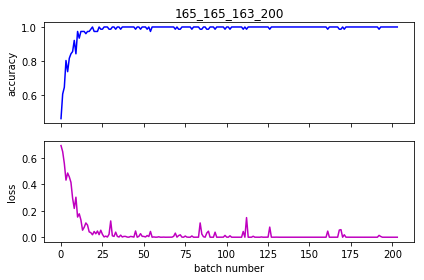

In [185]:
accuracy = np.array(history.accuracy)
losses = np.array(history.losses)

fig, ax = plt.subplots(2, sharex=True)

every_item = 100

ax[0].plot(accuracy[::every_item], color = 'b', marker='', ls='-')
ax[1].plot(losses[::every_item], color = 'm', marker='', ls='-')

ax[1].set_xlabel('batch number')
ax[0].set_ylabel('accuracy')
ax[1].set_ylabel('loss')

#ax[1].set_yscale('log')

ax[0].set_title(name)

plt.tight_layout()
plt.savefig(path_data + '/LossAcc::{}.png'.format(every_item))

### Score Distributions

In [186]:
# Get probs per image
probs = []

i=0 
for img in X_test_norm:
    #plt.imshow(np.squeeze(img), cmap='gray')
    
    img = np.reshape(img, [1,h,w,1])
    p = model.predict_proba(img, verbose=0)
    probs.append(np.squeeze(p))
    
    #name = "Good img" if Y_test[i, 1] == 1 else "Bad img"
    #plt.title('{}. Score: [{:.4f}, {:.4f}]'.format(name, p[0,0], p[0,1]))
    #plt.savefig('../Plots/TestImg/{}.png'.format(i))
    i+=1

probs = np.array(probs)

In [187]:
np.savetxt(path_data + 'ScoresOnTestData.txt', np.transpose([Y_test, probs]))

In [188]:
label_pos = Y_test
score_pos = probs[label_pos == 1]
score_neg = probs[label_pos == 0]

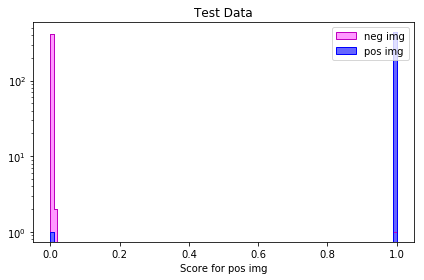

In [193]:
fig, ax = plt.subplots()

binsize = 0.01
bins = np.arange(0, 1 + binsize, binsize)

ax.hist(score_neg, bins=bins, histtype='stepfilled', linewidth=1, edgecolor='m', color='#ff99ff', label='neg img')
ax.hist(score_pos, bins=bins, histtype='stepfilled', linewidth=1, edgecolor='b', color='#6666ff', label='pos img')

ax.hist(score_neg, bins=bins, histtype='step', linewidth=1, linestyle='-', edgecolor='m')
ax.hist(score_pos, bins=bins, histtype='step', linewidth=1, linestyle='-',edgecolor='b')

ax.set_xlabel("Score for pos img")
ax.set_yscale('log')

ax.legend(loc='best')

plt.title('Test Data')

plt.tight_layout()
plt.savefig(path_data + 'ScoreDistributionOnTestData_{}.png'.format(binsize))

In [194]:
# positive images below 0.5
img_pos = X_test_norm[label_pos == 1]
img_pos_false = img_pos[score_pos < 0.5]
score_pos_false = score_pos[score_pos < 0.5]
print(img_pos_false.shape)

# negative images over 0.5
img_neg = X_test_norm[label_pos == 0]
img_neg_false = img_neg[score_neg > 0.5]
score_neg_false = score_neg[score_neg > 0.5]
print(img_neg_false.shape)

(1, 75, 100, 1)
(1, 75, 100, 1)


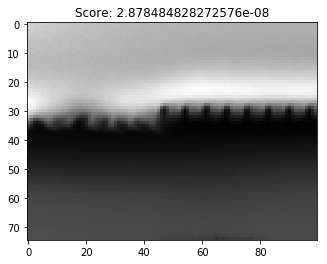

In [197]:
## wrongly classified pics:

for i, (pic,p) in enumerate(zip(img_pos_false[:], score_pos_false[:])):
    plt.imshow(np.squeeze(pic), cmap='gray')
    
    plt.title('Score: {:}'.format(p))
    plt.savefig(path_data + 'wrongImg/pos_{}.png'.format(i))
    plt.show()

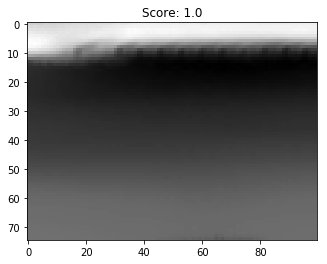

In [198]:
## wrongly classified pics:

for i, (pic,p) in enumerate(zip(img_neg_false[:], score_neg_false[:])):
    plt.imshow(np.squeeze(pic), cmap='gray')
    
    plt.title('Score: {:}'.format(p))
    plt.savefig(path_data + 'wrongImg/neg_{}.png'.format(i))
    plt.show()